In [1]:
import os

import pandas as pd
import numpy as np

In [2]:
phish = pd.read_csv('./CSV/phishing.csv')

In [3]:
phish.head()

,Index,UsingIP,LongURL,ShortURL,Symbol@,Redirecting//,PrefixSuffix-,SubDomains,HTTPS,DomainRegLen,...,UsingPopupWindow,IframeRedirection,AgeofDomain,DNSRecording,WebsiteTraffic,PageRank,GoogleIndex,LinksPointingToPage,StatsReport,class
0,0,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
1,1,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
2,2,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
3,3,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1
4,4,-1,0,-1,1,-1,-1,1,1,-1,...,1,1,1,1,1,-1,1,-1,-1,1


In [4]:
print(len(phish))

11054


In [5]:
#Drop all the suspicious label, only wish to keep phishing/legitimate

indexNames = phish[phish['class'] == 0 ].index
phish.drop(indexNames , inplace=True)

phish = phish.drop(["Index","Symbol@","Redirecting//","PrefixSuffix-","DomainRegLen","Favicon","NonStdPort","HTTPSDomainURL","LinksInScriptTags","InfoEmail","AbnormalURL","WebsiteForwarding","StatusBarCust","DisableRightClick","IframeRedirection","DNSRecording","PageRank","GoogleIndex","LinksPointingToPage","StatsReport","UsingIP"], axis = 1)

In [6]:
print(len(phish))

phish.head()

11054


,LongURL,ShortURL,SubDomains,HTTPS,RequestURL,AnchorURL,ServerFormHandler,UsingPopupWindow,AgeofDomain,WebsiteTraffic,class
0,1,1,0,1,1,0,-1,1,-1,0,-1
1,0,1,-1,-1,1,0,-1,1,1,1,-1
2,0,1,-1,-1,-1,0,-1,1,-1,1,-1
3,0,-1,1,1,1,0,-1,-1,-1,0,1
4,0,-1,1,1,1,0,-1,1,1,1,1


In [7]:

##Get the headers name of all columns into a list and remove the Result header as i do not wish to change the results
columns = phish.columns.values.tolist()
columns.remove('class')



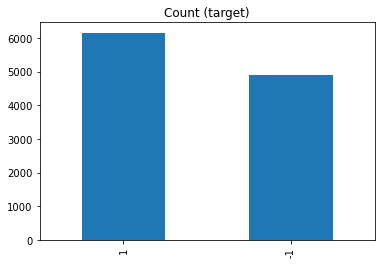

In [8]:
phish['class'].value_counts().plot(kind='bar', title='Count (target)');

In [9]:
## 1 is phishing, -1 is legitimate
phish['class'].unique()

##Since all have a IP Address there isnt a need for it
#phish = phish.drop(['having_IP_Address'], axis = 1)

array([-1,  1], dtype=int64)

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score

y = phish['class']
X = phish.drop(['class'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.30, random_state = 2)

# Gradient Boosting Algorithm

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

lrates = [0.01]
for learning_rate in lrates:
    GBC = GradientBoostingClassifier(learning_rate = learning_rate, n_estimators = 1000, max_depth=8, min_samples_split=2, min_samples_leaf=2, subsample=1, max_features='sqrt', random_state=10)
    GBC.fit(x_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(GBC.score(x_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(GBC.score(x_test, y_test)))

Learning rate:  0.01
Accuracy score (training): 0.952
Accuracy score (validation): 0.941


In [12]:
from sklearn.metrics import roc_auc_score, classification_report
prediction = GBC.predict(x_test)

prediction = prediction.astype(int)
y_test = y_test.astype(int)

print(roc_auc_score(y_test, prediction))
print(classification_report(y_test, prediction))

0.9401080348373796
              precision    recall  f1-score   support

          -1       0.93      0.93      0.93      1458
           1       0.95      0.95      0.95      1859

    accuracy                           0.94      3317
   macro avg       0.94      0.94      0.94      3317
weighted avg       0.94      0.94      0.94      3317



In [13]:
importances = pd.DataFrame({'Features':x_train.columns,'importance':np.round(GBC.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('Features')
importances.head(10)

,importance
Features,
HTTPS,0.473
AnchorURL,0.297
WebsiteTraffic,0.091
SubDomains,0.060
ServerFormHandler,0.023
RequestURL,0.021
AgeofDomain,0.012
LongURL,0.010
ShortURL,0.008


In [14]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(x_train, y_train)

# Predict
preds = xgb_cl.predict(x_test)

xgb_cl.score(x_test, y_test)

C:\Users\limju\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:49:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9397045523063009

In [15]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 1000, max_depth=8, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', random_state=10)


rfc.fit(x_train, y_train)
print("Learning rate: ", learning_rate)
print("Accuracy score (training): {0:.3f}".format(rfc.score(x_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(rfc.score(x_test, y_test)))

Learning rate:  0.01
Accuracy score (training): 0.939
Accuracy score (validation): 0.934


In [16]:
importances = pd.DataFrame({'Features':x_train.columns,'importance':np.round(rfc.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('Features')
importances.head(10)

,importance
Features,
HTTPS,0.468
AnchorURL,0.325
WebsiteTraffic,0.091
SubDomains,0.058
RequestURL,0.019
ServerFormHandler,0.018
LongURL,0.006
AgeofDomain,0.006
ShortURL,0.005
